In [67]:
# Core utilities
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Lifelines for survival modeling
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test

# scikit-survival for Random Survival Forests
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

# Warnings
import warnings
warnings.filterwarnings("ignore")

In [68]:
df = pd.read_excel("RADCURE_Clinical_v04_20241219.xlsx")
display(df.head())

,patient_id,Age,Sex,ECOG PS,Smoking PY,Smoking Status,Ds Site,Subsite,T,N,...,Local,Date Local,Regional,Date Regional,Distant,Date Distant,2nd Ca,Date 2nd Ca,RADCURE-challenge,ContrastEnhanced
0,RADCURE-0005,62.6,Female,ECOG 0,50,Ex-smoker,Oropharynx,post wall,T4b,N2c,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,0
1,RADCURE-0006,87.3,Male,ECOG 2,25,Ex-smoker,Larynx,Glottis,T1b,N0,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,1
2,RADCURE-0007,49.9,Male,ECOG 1,15,Ex-smoker,Oropharynx,Tonsil,T3,N2b,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,1
3,RADCURE-0009,72.3,Male,ECOG 1,30,Ex-smoker,Unknown,NaN,T0,N2c,...,NaN,NaT,NaN,NaT,NaN,NaT,S (suspicious),2008-05-27,0,0
4,RADCURE-0010,59.7,Female,ECOG 0,0,Non-smoker,Oropharynx,Tonsillar Fossa,T4b,N0,...,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0,0


In [ ]:
# Normalizing column names: lowercase, no spaces:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
print(df.columns.tolist())

# Removing duplicate columns and keeping the first occurrence:
df = df.loc[:, ~df.columns.duplicated()]

['patient_id', 'age', 'sex', 'ecog_ps', 'smoking_py', 'smoking_status', 'ds_site', 'subsite', 't', 'n', 'm', 'stage', 'path', 'hpv', 'tx_modality', 'chemo', 'rt_start', 'dose', 'fx', 'last_fu', 'status', 'length_fu', 'date_of_death', 'cause_of_death', 'local', 'date_local', 'regional', 'date_regional', 'distant', 'date_distant', '2nd_ca', 'date_2nd_ca', 'radcure-challenge', 'contrastenhanced']


In [70]:
# Converting relevant columns to datetime:
date_cols = ["rt_start", "last_fu", "date_of_death"]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")

In [55]:
# Using rt_start as the beginning of survival time:
df["end_date"] = df[["date_of_death", "last_fu"]].min(axis=1)

# Removing cases with no start or end date:
df = df.dropna(subset=["rt_start", "end_date"])

# Time in days
df["time"] = (df["end_date"] - df["rt_start"]).dt.days

# Event flag: death = 1, otherwise censored
df["event"] = df["date_of_death"].notna().astype(int)

In [56]:
# Cleaning and converting covariates:
df["Age"] = pd.to_numeric(df["age"], errors="coerce")
df["Sex"] = df["sex"].map({"Female": 0, "Male": 1})
df["ECOG"] = df["ecog_ps"].str.extract("(\d+)").astype(float)
df["Smoking"] = pd.to_numeric(df["smoking_py"], errors="coerce")

# Dropping rows missing required fields
df_model = df.dropna(subset=["time", "event", "Age", "Sex", "ECOG", "Smoking"]).copy()

# Selecting modeling features:
df_model = df_model[["time", "event", "Age", "Sex", "ECOG", "Smoking"]]
df_model.head()

,time,event,Age,Sex,ECOG,Smoking
0,446,1,62.6,0,0.0,50.0
1,527,1,87.3,1,2.0,25.0
2,756,0,49.9,1,1.0,15.0
3,2059,0,72.3,1,1.0,30.0
4,3444,0,59.7,0,0.0,0.0


In [58]:
print(type(df["age"]))
print(df["age"].head())

<class 'pandas.core.series.Series'>
0    62.6
1    87.3
2    49.9
3    72.3
4    59.7
Name: age, dtype: float64


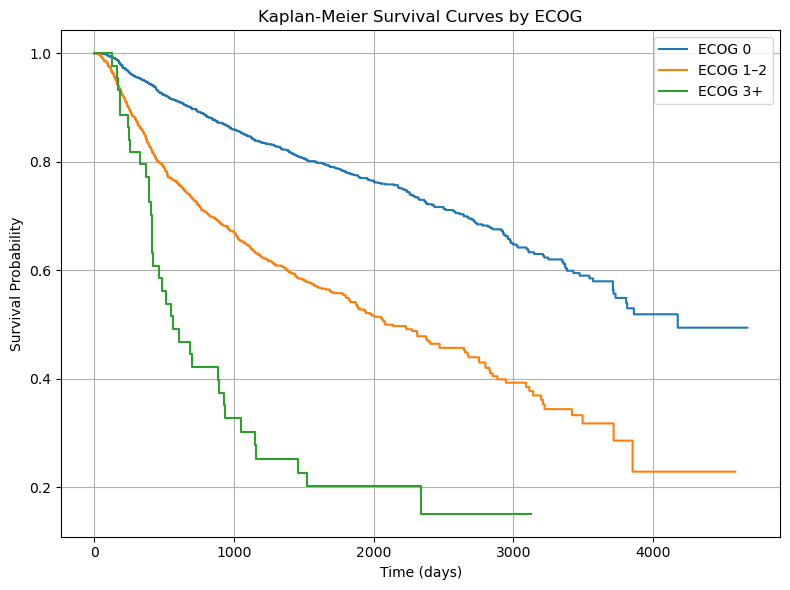

In [59]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Creating ECOG groups:
df_model["ECOG_group"] = pd.cut(
    df_model["ECOG"],
    bins=[-0.1, 0.5, 2.5, 5],
    labels=["ECOG 0", "ECOG 1–2", "ECOG 3+"]
)

# Fitting Kaplan-Meier curves for each group:
kmf = KaplanMeierFitter()

plt.figure(figsize=(8, 6))
for group in df_model["ECOG_group"].dropna().unique():
    sub = df_model[df_model["ECOG_group"] == group]
    kmf.fit(sub["time"], sub["event"], label=str(group))
    kmf.plot(ci_show=False)

plt.title("Kaplan-Meier Survival Curves by ECOG")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.tight_layout()
plt.show()

In [60]:
from lifelines.statistics import multivariate_logrank_test

# For ECOG groups (or switch to age_group):
logrank_result = multivariate_logrank_test(
    event_durations=df_model["time"],
    groups=df_model["ECOG_group"],
    event_observed=df_model["event"]
)

logrank_result.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         279.54 <0.005    201.65

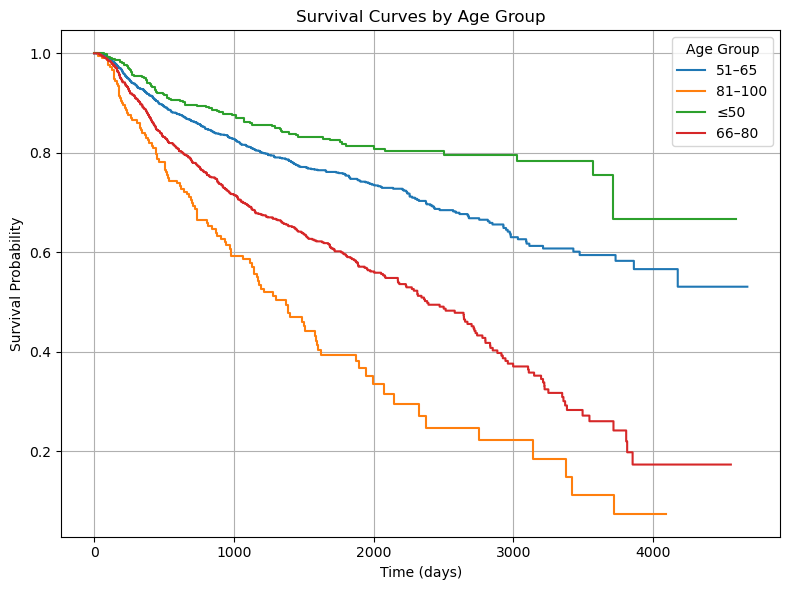

In [61]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import pandas as pd

# Categorizing age into bins:
df_model["age_group"] = pd.cut(
    df_model["Age"],
    bins=[0, 50, 65, 80, 100],
    labels=["≤50", "51–65", "66–80", "81–100"]
)

# Fitting KM curves per age group:
kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))

for group in df_model["age_group"].dropna().unique():
    subset = df_model[df_model["age_group"] == group]
    kmf.fit(subset["time"], subset["event"], label=str(group))
    kmf.plot(ci_show=False)

plt.title("Survival Curves by Age Group")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.legend(title="Age Group")
plt.grid(True)
plt.tight_layout()
plt.show()

In [62]:
age_logrank_result = multivariate_logrank_test(
    event_durations=df_model["time"],
    groups=df_model["age_group"],
    event_observed=df_model["event"]
)

age_logrank_result.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         226.80 <0.005    160.01

In [63]:
from lifelines import CoxPHFitter

cox_model = CoxPHFitter()
cox_model.fit(df_model[["time", "event", "Age", "Sex", "ECOG"]], duration_col="time", event_col="event")
cox_model.print_summary()

<lifelines.CoxPHFitter: fitted with 3258 total observations, 2238 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 3258
number of events observed = 1020
   partial log-likelihood = -7448.01
         time fit was run = 2025-07-14 22:40:47 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
Age        0.04      1.04      0.00            0.03            0.04                1.03                1.04
Sex        0.07      1.08      0.08           -0.08            0.23                0.92                1.26
ECOG       0.57      1.76      0.04            0.49            0.64                1.64                1.90

           cmp to     z      p  -log2(p)
covariate                               
Age          0.00 12.76 <0.005    121.43
Sex          0.00  0.94   0.35      1.52
ECOG         0.00 14.99 <0.005    166.39
---
Concordance = 0.68
Partial AIC = 14902.02
log-likelihood ratio test = 425.39 on 3 df
-log2(p) of ll-ratio test = 302.81

In [64]:
from sksurv.util import Surv
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import train_test_split

# Preparing survival object and splitting data:
y_rsf = Surv.from_dataframe("event", "time", df_model)
X_rsf = df_model[["Age", "Sex", "ECOG", "Smoking"]]

X_train, X_test, y_train, y_test = train_test_split(X_rsf, y_rsf, test_size=0.25, random_state=42)

# Fit RSF
rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, min_samples_leaf=10, random_state=42)
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=10, min_samples_split=10, random_state=42)

Random Survival Forest C-index: 0.687


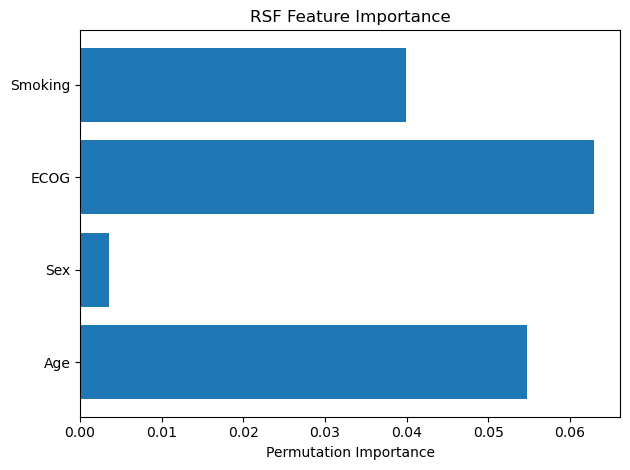

In [65]:
from sksurv.metrics import concordance_index_censored
from sklearn.inspection import permutation_importance

# Evaluating RSF performance:
rsf_cindex = concordance_index_censored(y_test["event"], y_test["time"], rsf.predict(X_test))[0]
print("Random Survival Forest C-index:", round(rsf_cindex, 3))

# Computing permutation importance:
perm_result = permutation_importance(rsf, X_test, y_test, n_repeats=10, random_state=1)
importances = perm_result.importances_mean

# Plotting results:
plt.barh(X_rsf.columns, importances)
plt.xlabel("Permutation Importance")
plt.title("RSF Feature Importance")
plt.tight_layout()
plt.show()